In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
# %matplotlib qt
%matplotlib inline
dataset = pd.read_csv("traindata.csv")

<BarContainer object of 15 artists>

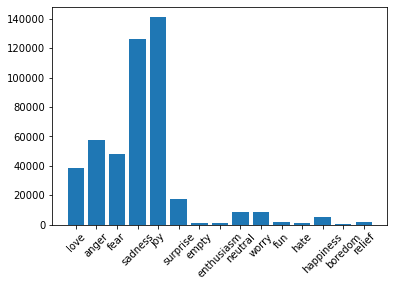

In [2]:
plotdata={}
for i in dataset.emotions.unique():
    plotdata[i]=len(dataset[dataset['emotions']==i])

plt.xticks(rotation = 45)
plt.bar(plotdata.keys(),plotdata.values())

In [3]:
dataset.head(10)

,Unnamed: 0,text,emotions
0,1,i maybe i up being now smaller compared people...,love
1,2,i have been hearing rumours that you have not ...,anger
2,3,a nearaccident in a car,fear
3,4,no response,sadness
4,5,a boy i had been admiring so much asked me to ...,joy
5,6,i m already feeling somewhat strange given tha...,surprise
6,7,i was at a friends place for lunch and she fel...,anger
7,8,i myself smiling through loving simple dialog ...,surprise
8,9,i feel are caring cross on back right now put ...,love
9,10,years ago my family decided to move from new y...,sadness


### Tokenization

In [4]:
#converting a sentence into word list
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].unique().tolist()
emotions = dataset["emotions"].tolist()

### Creating Vocabulary (word index)

In [5]:
#printing all labels that is available 
for i, l in enumerate(labels):
    print(i,l)

0 love
1 anger
2 fear
3 sadness
4 joy
5 surprise
6 empty
7 enthusiasm
8 neutral
9 worry
10 fun
11 hate
12 happiness
13 boredom
14 relief


In [6]:
# making a dictonary to convert word to index and index to word for doing one hot encoding
word2id = dict()
label2id = dict()

max_words = 0

for sentence in input_sentences:
    for word in sentence:
        
        if word not in word2id:
            word2id[word] = len(word2id)
    if len(sentence) > max_words:
        max_words = len(sentence)
    

label2id = {l: i for i, l in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

In [7]:
import keras


X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in emotions]


from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)


Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')


print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Shape of X: (456809, 178)
Shape of Y: (456809, 15)


In [8]:
embedding_dim = 100 
sequence_input = keras.Input(shape=(max_words,), dtype='int32')
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,embedding_dim,input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)


input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 178, 100)     12824900    input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 178, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 178, 200)     160800      dropout[0][0]                    
_______________________________________________________________________________________

## Training the model

In [9]:
from  keras.models import load_model

# to train the model execute model.fit line

#model.fit(X, Y, epochs=4, batch_size=32, validation_split=0.1, shuffle=True)


# as i have already trian my model so here i just called my saved train model
model=load_model('trainmodel.h5')

In [10]:
def predictmodel(text):
    tokenized_sample = text.split(" ")
    encoded_samples = [[word2id[word] for word in tokenized_sample]]
    encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)
    label_probs = model.predict(encoded_samples)
    label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}
    return label_probs

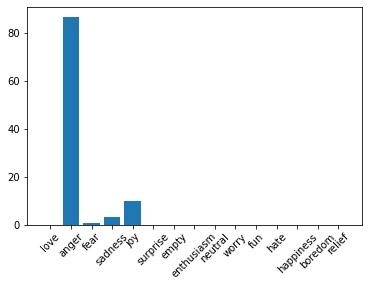

In [11]:
ans=predictmodel("we are not learning through our online course")
plt.bar(ans.keys(),[x*100 for x in ans.values()])
plt.xticks(rotation = 45)
plt.show()

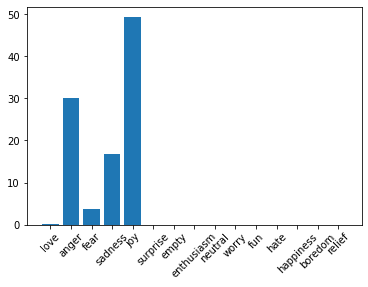

In [12]:
ans=predictmodel('when i saw a person i had not seen for a long time')
plt.bar(ans.keys(),[x*100 for x in ans.values()])
plt.xticks(rotation = 45)
plt.show()

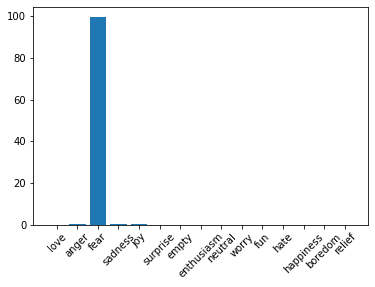

In [13]:
ans=predictmodel('when i woke up in the middle of the night because of a dream')
plt.bar(ans.keys(),[x*100 for x in ans.values()])
plt.xticks(rotation = 45)
plt.show()

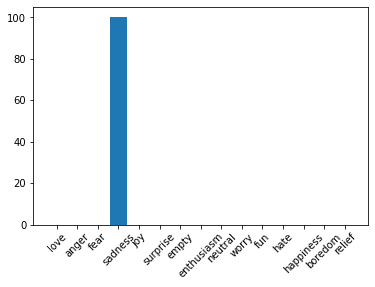

In [14]:
ans=predictmodel('i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here')
plt.bar(ans.keys(),[x*100 for x in ans.values()])
plt.xticks(rotation = 45)
plt.show()

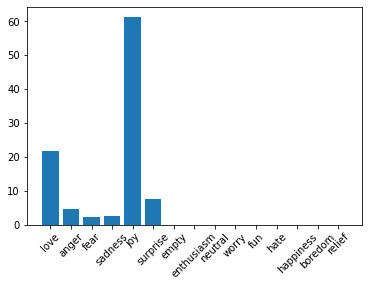

In [15]:
ans=predictmodel('dont make me feel love')
plt.bar(ans.keys(),[x*100 for x in ans.values()])
plt.xticks(rotation = 45)
plt.show()